In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define paths (Use double backslashes for Windows)
base_path = r"D:\diabetic retinopathy\path_to_train_images"

train_csv_path = os.path.join(base_path, "train_1.csv")
valid_csv_path = os.path.join(base_path, "valid.csv")
test_csv_path = os.path.join(base_path, "test.csv")

train_img_path = os.path.join(base_path, "train_images")
valid_img_path = os.path.join(base_path, "val_images")
test_img_path = os.path.join(base_path, "test_images")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Debug: Check if paths exist
assert os.path.exists(train_csv_path), f"❌ Error: Train CSV not found at {train_csv_path}"
assert os.path.exists(valid_csv_path), f"❌ Error: Valid CSV not found at {valid_csv_path}"
assert os.path.exists(test_csv_path), f"❌ Error: Test CSV not found at {test_csv_path}"
assert os.path.exists(train_img_path), f"❌ Error: Train image folder not found at {train_img_path}"
assert os.path.exists(valid_img_path), f"❌ Error: Validation image folder not found at {valid_img_path}"
assert os.path.exists(test_img_path), f"❌ Error: Test image folder not found at {test_img_path}"

print("✅ All paths are correctly set!")


✅ All paths are correctly set!


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image

# ✅ Preprocessing function with error handling
def preprocess_image(image):
    if image is None:
        print("❌ Warning: Image is None, skipping preprocessing!")
        return np.zeros((380, 380, 3), dtype=np.uint8)  # Return a black image

    # Convert to grayscale for CLAHE
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # Convert back to RGB
    image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Circular mask
    height, width = image.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)
    center = (width // 2, height // 2)
    radius = min(width, height) // 2 - 5  # ✅ Slightly reduced cropping
    cv2.circle(mask, center, radius, 255, -1)
    image = cv2.bitwise_and(image, image, mask=mask)
    
    return image

# ✅ Custom Dataset Class with Error Handling
class APTOSDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, preprocess=True):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.preprocess = preprocess
        self.valid_samples = self._filter_missing_images()

    def _filter_missing_images(self):
        valid_samples = []
        for idx in range(len(self.data)):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + ".png")
            if os.path.exists(img_name):  # ✅ Skip missing files
                valid_samples.append(idx)
            else:
                print(f"⚠️ Skipping missing image: {img_name}")
        return valid_samples

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        real_idx = self.valid_samples[idx]
        img_name = os.path.join(self.img_dir, self.data.iloc[real_idx, 0] + ".png")
        
        image = cv2.imread(img_name)
        if image is None:
            print(f"❌ Error reading image: {img_name}, using blank image.")
            image = np.zeros((380, 380, 3), dtype=np.uint8)  # Use a blank image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.preprocess:
            image = preprocess_image(image)

        label = int(self.data.iloc[real_idx, 1])  # Assuming label is in 2nd column

        if self.transform:
            image = Image.fromarray(image)  # ✅ Convert numpy array to PIL Image
            image = self.transform(image)

        return image, label

# ✅ Data Augmentation & Normalization
train_transforms = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Datasets
train_dataset = APTOSDataset(train_csv_path, train_img_path, transform=train_transforms)
valid_dataset = APTOSDataset(valid_csv_path, valid_img_path, transform=valid_transforms)
test_dataset = APTOSDataset(test_csv_path, test_img_path, transform=valid_transforms)

# ✅ Handle Class Imbalance with WeightedRandomSampler
train_labels = train_dataset.data.iloc[train_dataset.valid_samples, 1].values  # ✅ Fix indexing
class_counts = np.bincount(train_labels)

# Avoid division by zero
class_weights = np.zeros_like(class_counts, dtype=np.float32)
nonzero_mask = class_counts > 0
class_weights[nonzero_mask] = 1.0 / class_counts[nonzero_mask]

sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# ✅ Data Loaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=0)  # 🔥 Use num_workers=0 for Windows
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\0ce062f26edc.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\1120f6d08d95.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\13073f075a56.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\0efc93ec838b.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\194814669fee.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\0a38b552372d.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\1006345f70b7.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\0232dfea7547.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_images\13d71389563f.png
⚠️ Skipping missing image: D:\diabetic retinopathy\path_to_train_images\train_imag

In [3]:
class EfficientNetB5(nn.Module):
    def __init__(self, num_classes=5):
        super(EfficientNetB5, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b5')
        self.model._fc = nn.Linear(self.model._fc.in_features, num_classes)
        self.features = None
        self.gradients = None
        
        # Hook the last convolutional layer for Grad-CAM++
        self.model._conv_head.register_forward_hook(self.save_features)
        self.model._conv_head.register_full_backward_hook(self.save_gradients)  # ✅ FIXED HERE

    def save_features(self, module, input, output):
        self.features = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def forward(self, x):
        return self.model(x)

    def extract_features(self, x):
        self.model.eval()
        _ = self.model(x)
        return self.features

# Initialize model
model = EfficientNetB5(num_classes=5).to(device)

Loaded pretrained weights for efficientnet-b5


In [4]:
# Weighted loss
class_weights = torch.FloatTensor(1.0 / class_counts).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [5]:
def train_model(num_epochs=20, patience=5):
    global optimizer  # ✅ Add this if `optimizer` is defined outside the function

    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # ✅ Define before loop

    best_kappa = -float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # ✅ Now optimizer is properly initialized
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, preds = torch.max(outputs, 1)
                valid_preds.extend(preds.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())
        
        valid_loss /= len(valid_loader.dataset)
        kappa = cohen_kappa_score(valid_labels, valid_preds, weights='quadratic')
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Kappa: {kappa:.4f}")
        
        # Scheduler step
        scheduler.step(valid_loss)
        
        # Early stopping
        if kappa > best_kappa:
            best_kappa = kappa
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    # Fine-tuning: Unfreeze the last few layers
    for param in model.model._blocks[-10:].parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # ✅ Redefine for fine-tuning
    
    for epoch in range(5):  # Fine-tune for 5 more epochs
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Fine-Tune Epoch {epoch+1}/5"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        valid_loss = 0.0
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                valid_preds.extend(preds.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())
        
        valid_loss /= len(valid_loader.dataset)
        kappa = cohen_kappa_score(valid_labels, valid_preds, weights='quadratic')
        
        print(f"Fine-Tune Epoch {epoch+1}/5, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Kappa: {kappa:.4f}")


# Protect the main execution
if __name__ == "__main__":
    # Update DataLoader with num_workers=0 (or a smaller number like 2)
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler, num_workers=0)  # Changed to 0
    valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)   # Changed to 0
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)     # Changed to 0
    
    # Train the model
    train_model()

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:14<00:00,  5.13s/it]


Epoch 1/20, Train Loss: 1.1245, Valid Loss: 1.5289, Kappa: 0.5078


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:10<00:00,  5.12s/it]


Epoch 2/20, Train Loss: 0.8010, Valid Loss: 0.8449, Kappa: 0.9036


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:11<00:00,  5.12s/it]


Epoch 3/20, Train Loss: 0.6294, Valid Loss: 0.6464, Kappa: 0.9228


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:05<00:00,  5.10s/it]


Epoch 4/20, Train Loss: 0.5193, Valid Loss: 0.6037, Kappa: 0.8652


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:07<00:00,  5.11s/it]


Epoch 5/20, Train Loss: 0.4435, Valid Loss: 0.9017, Kappa: 0.9300


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:03<00:00,  5.10s/it]


Epoch 6/20, Train Loss: 0.3968, Valid Loss: 1.2945, Kappa: 0.9036


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:08<00:00,  5.11s/it]


Epoch 7/20, Train Loss: 0.3103, Valid Loss: 0.7719, Kappa: 0.8737


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:15<00:00,  5.14s/it]


Epoch 8/20, Train Loss: 0.2734, Valid Loss: 0.8945, Kappa: 0.9162
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 295/295 [25:08<00:00,  5.11s/it]


Epoch 9/20, Train Loss: 0.2506, Valid Loss: 1.0347, Kappa: 0.9162


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 295/295 [25:06<00:00,  5.11s/it]


Epoch 10/20, Train Loss: 0.2311, Valid Loss: 1.2777, Kappa: 0.9116
Early stopping triggered.


Fine-Tune Epoch 1/5: 100%|███████████████████████████████████████████████████████████| 295/295 [25:15<00:00,  5.14s/it]


Fine-Tune Epoch 1/5, Train Loss: 0.1711, Valid Loss: 1.0290, Kappa: 0.9300


Fine-Tune Epoch 2/5: 100%|███████████████████████████████████████████████████████████| 295/295 [24:38<00:00,  5.01s/it]


Fine-Tune Epoch 2/5, Train Loss: 0.1565, Valid Loss: 0.9904, Kappa: 0.9300


Fine-Tune Epoch 3/5: 100%|███████████████████████████████████████████████████████████| 295/295 [25:17<00:00,  5.14s/it]


Fine-Tune Epoch 3/5, Train Loss: 0.1521, Valid Loss: 1.1555, Kappa: 0.9480


Fine-Tune Epoch 4/5: 100%|███████████████████████████████████████████████████████████| 295/295 [24:45<00:00,  5.04s/it]


Fine-Tune Epoch 4/5, Train Loss: 0.1283, Valid Loss: 1.0038, Kappa: 0.9656


Fine-Tune Epoch 5/5: 100%|███████████████████████████████████████████████████████████| 295/295 [25:03<00:00,  5.10s/it]


Fine-Tune Epoch 5/5, Train Loss: 0.1384, Valid Loss: 0.9346, Kappa: 0.9656


In [7]:
torch.save(model.state_dict(), "best_model.pth")


In [8]:
def evaluate_model():
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    kappa = cohen_kappa_score(test_labels, test_preds, weights='quadratic')
    print(f"Test Cohen's Kappa: {kappa:.4f}")

evaluate_model()

Test Cohen's Kappa: 0.8483


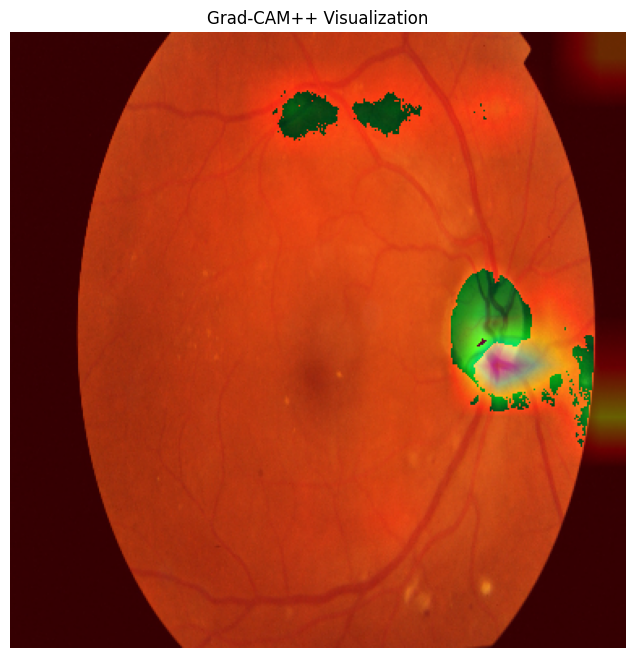

In [10]:
from PIL import Image

def compute_gradcam_plus_plus(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    
    # Forward pass
    output = model(image)
    score = output[0, target_class]
    
    # Backward pass
    model.zero_grad()
    score.backward()
    
    gradients = model.gradients
    features = model.features
    
    # Grad-CAM++ weights
    alpha_num = gradients ** 2
    alpha_denom = 2 * (gradients ** 2) + torch.sum(features * (gradients ** 3), dim=(2, 3), keepdim=True)
    alpha_denom = torch.where(alpha_denom != 0, alpha_denom, torch.ones_like(alpha_denom))
    alpha = alpha_num / alpha_denom
    
    weights = F.relu(torch.sum(alpha * F.relu(gradients), dim=(2, 3), keepdim=True))
    heatmap = torch.sum(weights * features, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def plot_gradcam(image_path, heatmap):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (380, 380))
    
    heatmap = cv2.resize(heatmap, (380, 380))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.axis('off')
    plt.title("Grad-CAM++ Visualization")
    plt.show()

# Visualize Grad-CAM++ for a test image
test_image_path = os.path.join(test_img_path, "e4e343eaae2a.png")
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Convert to PIL and apply transforms
test_image_pil = Image.fromarray(test_image)
test_image_tensor = valid_transforms(test_image_pil).to(device)

# Predict the class
model.eval()
with torch.no_grad():
    output = model(test_image_tensor.unsqueeze(0))
    predicted_class = torch.argmax(output, dim=1).item()

heatmap = compute_gradcam_plus_plus(model, test_image_tensor, target_class=predicted_class)
plot_gradcam(test_image_path, heatmap)


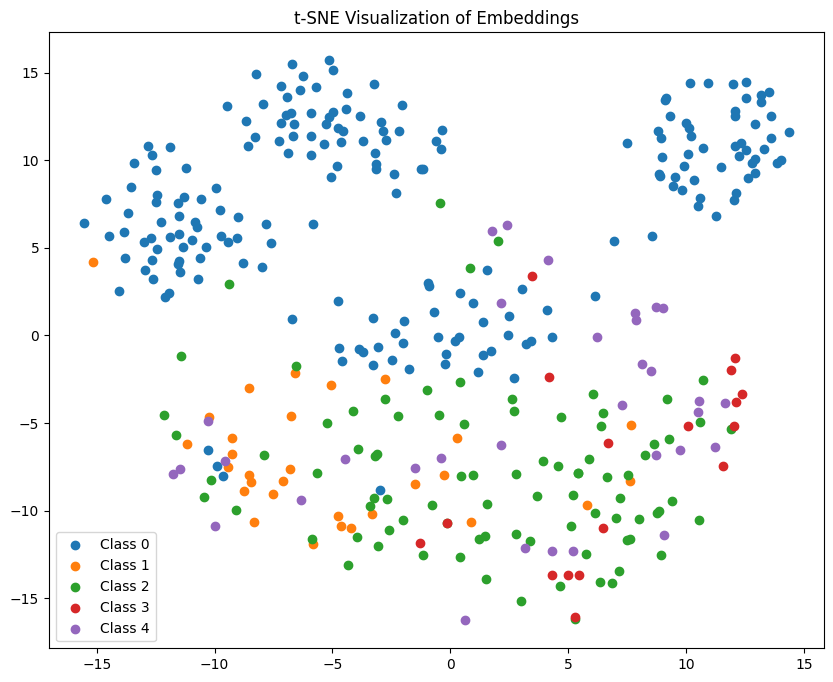

In [11]:
def visualize_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            features = model.extract_features(images)
            embeddings.append(features.cpu().numpy())
            labels.append(targets.numpy())
    
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    
    # Reshape embeddings
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(5):
        idx = labels == i
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {i}')
    plt.legend()
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

# Visualize embeddings on the test set
visualize_embeddings(model, test_loader)